In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import json

In [2]:
hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
thalamic_nuclei = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
with open("/home/srs-9/Projects/ms_mri/longitudinal_pipeline/all_longitudinal_sessions.json", 'r') as f:
    subject_sessions = json.load(f)
df_long = pd.read_csv("/home/srs-9/Projects/ms_mri/longitudinal_pipeline/data0/left_volumes_long.csv").set_index(["subid", "sesid"])

groups = {
    "medial": ["MD_Pf_12", "CM_11"],
    "ventral": ["VA_4", "VLa_5", "VLP_6", "VPL_7"],
    "posterior": ["Pul_8", "MGN_10", "LGN_9"],
    "anterior": ["AV_2"]
}
for group, nucs in groups.items():
    cols = [nuc for nuc in nucs]
    df_long[group] = df_long[cols].sum(axis=1)
    

In [3]:
subids = sorted(list(set([idx[0] for idx in df_long.index])))
for subid in subids:
    ses_data = df_long.loc[subid, :]
    ses1 = ses_data.index[0]
    for ses in ses_data.index:
        df_long.loc[(subid,ses), "datetime"] = pd.to_datetime(ses, format='%Y%m%d')
        df_long.loc[(subid,ses), "datetime_delta"] = (df_long.loc[(subid,ses), "datetime"] - df_long.loc[(subid,ses1), "datetime"]).days / 365
        for struct in hips_thomas_ref.to_list() + list(groups.keys()):
            df_long.loc[(subid,ses), f"{struct}_ch"] = ses_data.loc[ses, struct] - ses_data.loc[ses1, struct]
            df_long.loc[(subid,ses), f"{struct}_pct_ch"] = df_long.loc[(subid,ses), f"{struct}_ch"] / ses_data.loc[ses1, struct]
            if df_long.loc[(subid,ses), "datetime_delta"] > 0:
                df_long.loc[(subid,ses), f"{struct}_ch_ann"] = df_long.loc[(subid,ses), f"{struct}_ch"] / df_long.loc[(subid,ses), "datetime_delta"]
                df_long.loc[(subid,ses), f"{struct}_pct_ch_ann"] = df_long.loc[(subid,ses), f"{struct}_pct_ch"] / df_long.loc[(subid,ses), "datetime_delta"]
            else:
                df_long.loc[(subid,ses), f"{struct}_ch_ann"] = None
                df_long.loc[(subid,ses), f"{struct}_pct_ch_ann"] = None
        ses1 = ses
    

In [4]:
cols_ordered = ["t_diff", "datetime", "datetime_delta"]
suffix_order = ["", "_ch", "_ch_ann", "_pct_ch", "_pct_ch_ann"]
for struct in [hips_thomas_ref[1]] + list(groups.keys()) + hips_thomas_ref[1:].to_list():
    cols_ordered.extend([f"{struct}{suffix}" for suffix in suffix_order])

df_long = df_long[cols_ordered]

In [5]:
df_long

t_diff   datetime  datetime_delta   THALAMUS_1  \
subid sesid                                                        
1001  20170215  0.000000 2017-02-15        0.000000  4566.070312   
      20180323  1.097878 2018-03-23        1.098630  4528.476074   
      20200523  3.266256 2020-05-23        2.169863  4469.093262   
1003  20170329  0.000000 2017-03-29        0.000000  4643.693848   
      20180406  1.021218 2018-04-06        1.021918  4701.696289   
...                  ...        ...             ...          ...   
3021  20190801  2.702259 2019-08-01        1.142466  2613.770020   
      20220216  5.248460 2022-02-16        2.547945  2600.457764   
3023  20170727  0.000000 2017-07-27        0.000000  4200.078613   
      20191203  2.351814 2019-12-03        2.353425  4132.241699   
      20220330  4.673511 2022-03-30        2.323288  4296.706543   

                THALAMUS_1_ch THALAMUS_1_ch_ann  THALAMUS_1_pct_ch  \
subid sesid                                                          
1001  20170215       0.000000              None           0.000000   
      20180323     -37.594238        -34.219194          -0.008233   
      20200523     -59.382812        -27.367079          -0.013113   
1003  20170329       0.000000              None           0.000000   
      20180406      58.002441         56.758421           0.012491   
...                       ...               ...                ...   
3021  20190801       8.720704           7.63323           0.003348   
      20220216     -13.312256         -5.224703          -0.005093   
3023  20170727       0.000000              None           0.000000   
      20191203     -67.836914        -28.824766          -0.016151   
      20220330     164.464844         70.789703           0.039800   

               THALAMUS_1_pct_ch_ann      medial  medial_ch  ...       GP_33  \
subid sesid                                                  ...               
1001  20170215                  None  707.592453   0.000000  ...  559.110718   
      20180323             -0.007494  676.404037 -31.188416  ...  522.280212   
      20200523             -0.006043  676.406090   0.002053  ...  579.630371   
1003  20170329                  None  759.355743   0.000000  ...  665.652405   
      20180406              0.012223  768.512123   9.156380  ...  701.440063   
...                              ...         ...        ...  ...         ...   
3021  20190801               0.00293  443.905693 -13.309128  ...  568.834167   
      20220216             -0.001999  440.321624  -3.584069  ...  580.098145   
3023  20170727                  None  642.069831   0.000000  ...  539.666321   
      20191203             -0.006863  627.183258 -14.886573  ...  606.703735   
      20220330              0.017131  623.104363  -4.078895  ...  564.736328   

                 GP_33_ch GP_33_ch_ann  GP_33_pct_ch  GP_33_pct_ch_ann  \
subid sesid                                                              
1001  20170215   0.000000         None      0.000000              None   
      20180323 -36.830506   -33.524027     -0.065873          -0.05996   
      20200523  57.350159    26.430313      0.109807          0.050606   
1003  20170329   0.000000         None      0.000000              None   
      20180406  35.787658    35.020094      0.053763           0.05261   
...                   ...          ...           ...               ...   
3021  20190801  61.955505    54.229639      0.122229          0.106987   
      20220216  11.263978     4.420809      0.019802          0.007772   
3023  20170727   0.000000         None      0.000000              None   
      20191203  67.037414    28.485048      0.124220          0.052783   
      20220330 -41.967407   -18.063801     -0.069173         -0.029774   

                     Amy_34   Amy_34_ch Amy_34_ch_ann  Amy_34_pct_ch  \
subid sesid                                                            
1001  20170215  1222.670654    0.000000          None       0.000000   
  

In [8]:
check_subs = [sub for sub in subids if len(df_long.loc[sub, :])>4]
len(check_subs)

18

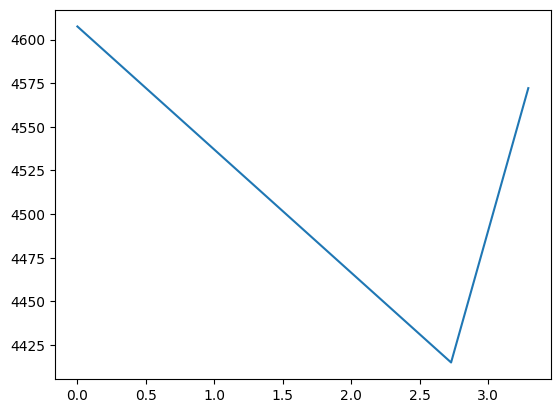

In [13]:
subid = 1046
struct = "THALAMUS_1"
x = df_long.loc[subid, "t_diff"]
y = df_long.loc[subid, struct]
plt.plot(x, y)
plt.show()

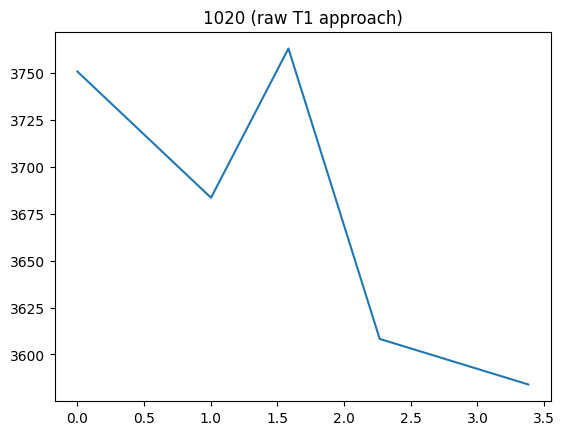

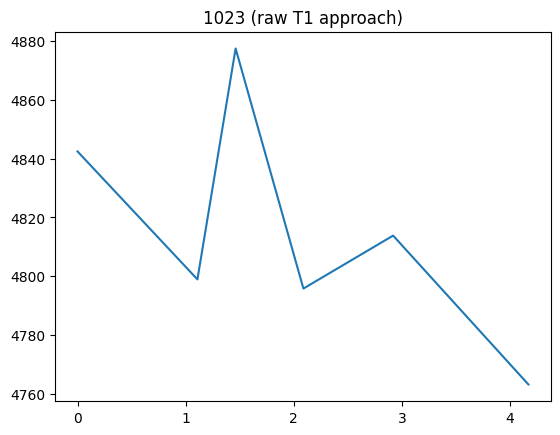

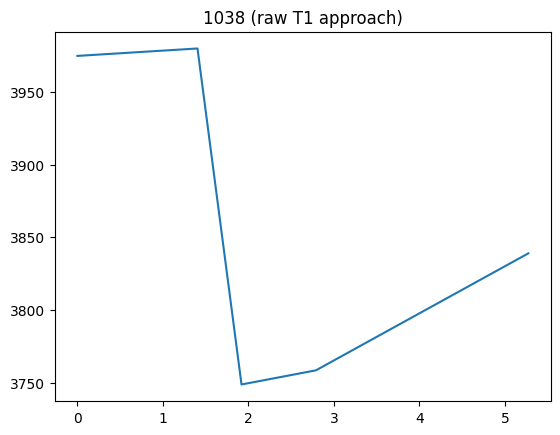

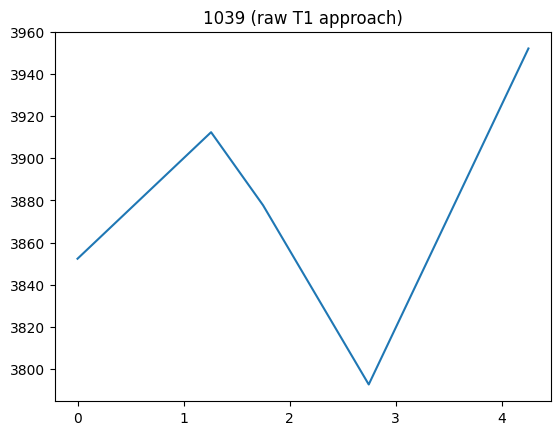

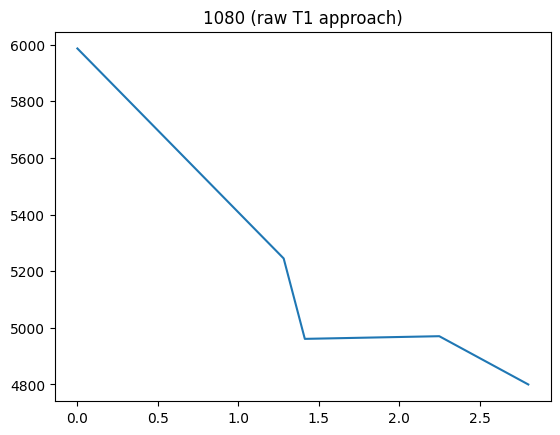

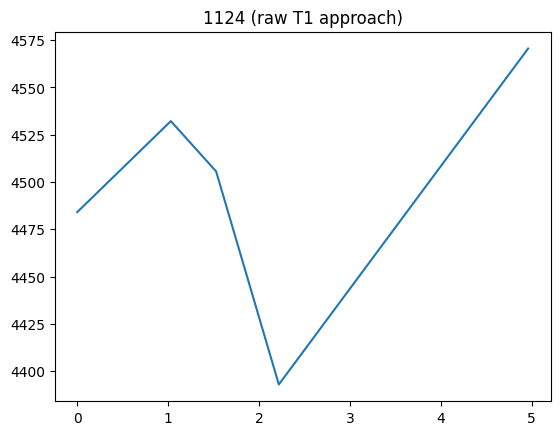

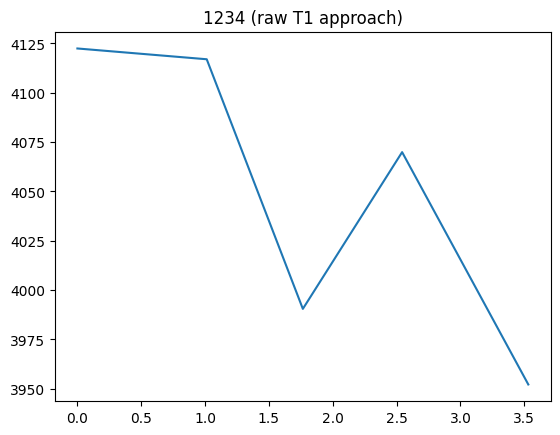

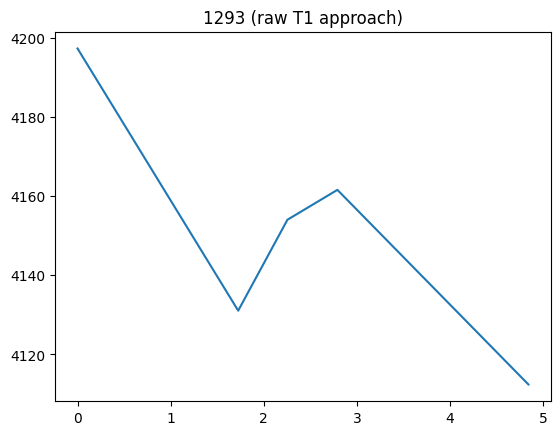

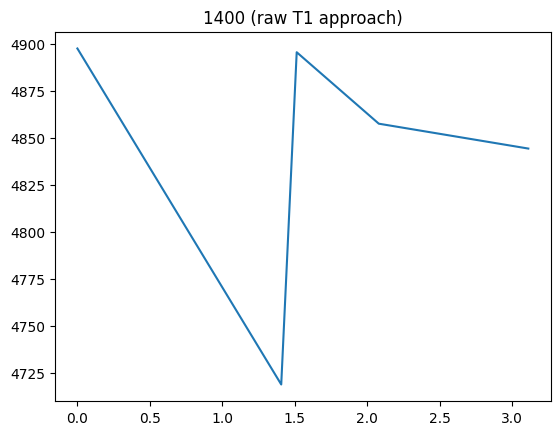

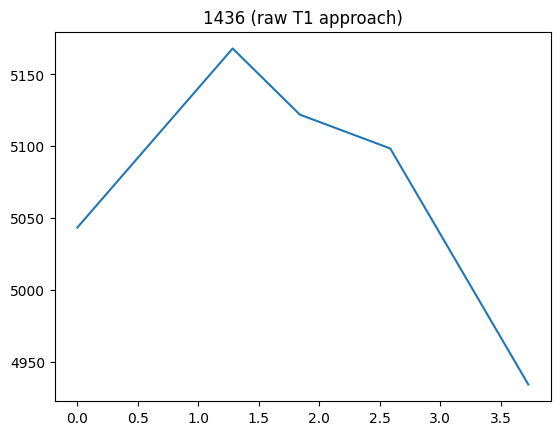

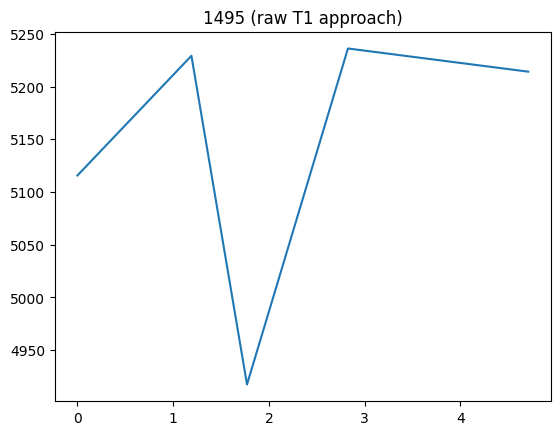

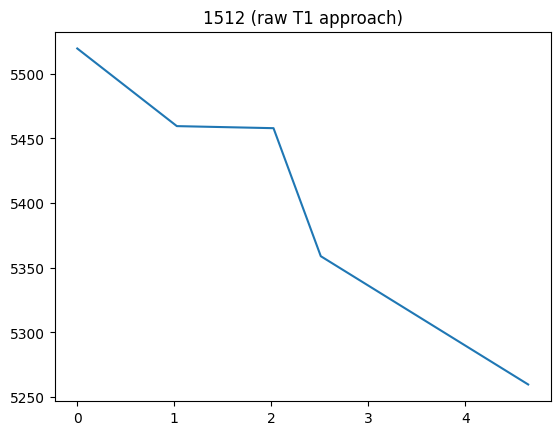

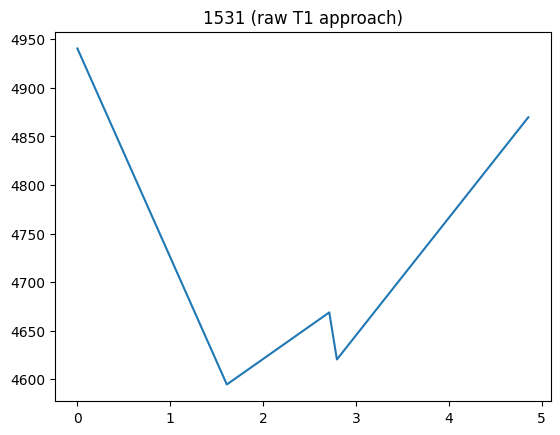

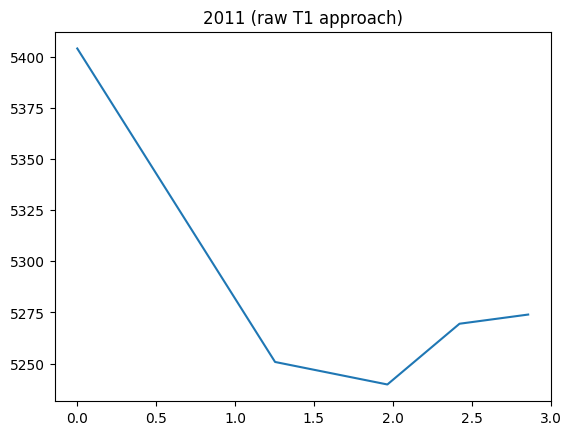

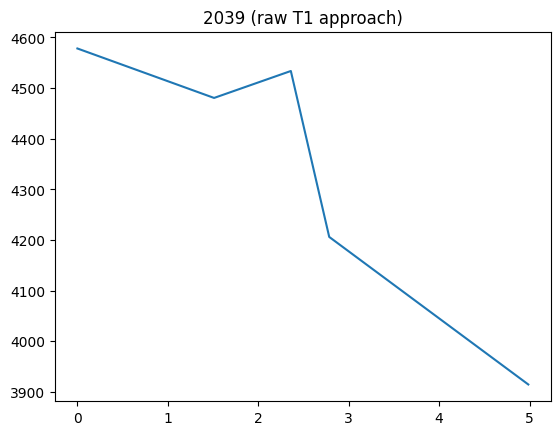

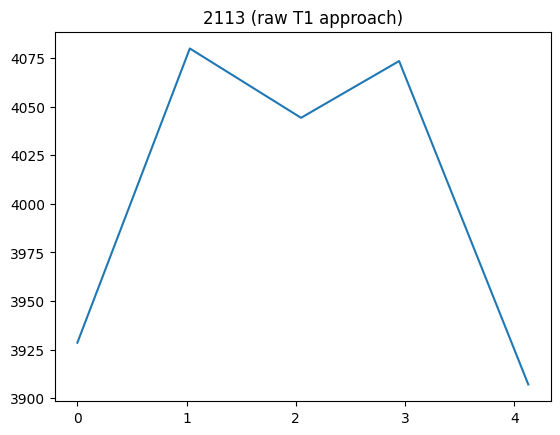

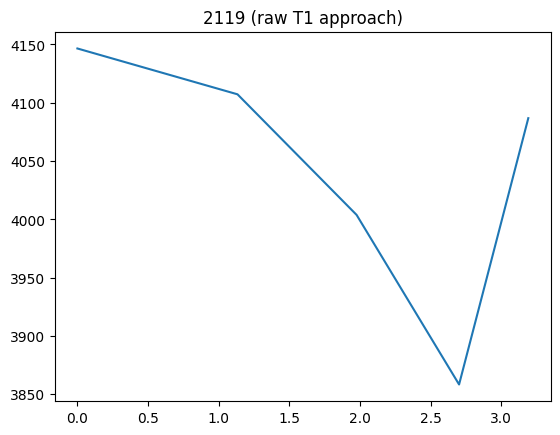

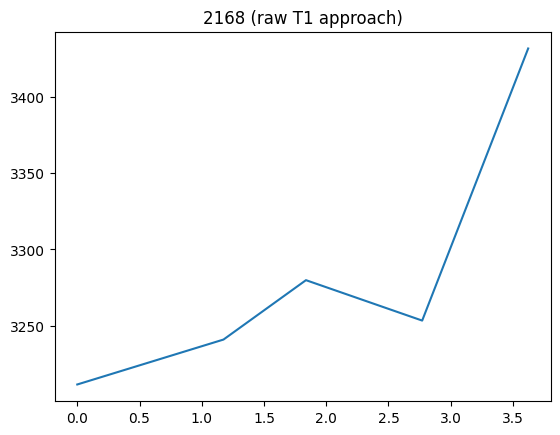

In [14]:
subid = 1003
struct = "THALAMUS_1"
for subid in check_subs:
    x = df_long.loc[subid, "t_diff"]
    y = df_long.loc[subid, struct]
    plt.plot(x, y)
    plt.title(f"{subid} (raw T1 approach)")
    plt.show()

In [ ]:
for sub in check_subs:
    

False

In [20]:
(pd.to_datetime(20200523, format='%Y%m%d') - pd.to_datetime(20170523, format='%Y%m%d')).days

1096

In [15]:
df_long.loc[subid, :]


,t_diff,THALAMUS_1,AV_2,VA_4,VLa_5,VLP_6,VPL_7,Pul_8,LGN_9,MGN_10,...,Acc_26,Cau_27,Cla_28,GPe_29,GPi_30,Put_31,RN_32,GP_33,Amy_34,datetime
sesid,,,,,,,,,,,,,,,,,,,,,
20170215,0.000000,9048.171874,81.920983,441.861267,120.833439,1223.182617,529.414353,2262.042968,194.050331,86.529041,...,989.195801,5468.737549,1145.357728,598.023132,335.364044,8233.570801,409.092895,1132.045593,2471.453613,2017-02-15
20180323,1.097878,9012.405273,86.022623,441.889969,123.401493,1203.804627,508.455124,2297.520752,198.159256,89.606891,...,965.706298,5398.943116,1122.390381,548.906219,321.560730,8205.942871,373.788742,1050.192810,2483.391114,NaT
20200523,3.266256,9010.384278,97.287781,415.777252,112.649006,1210.976868,525.866073,2164.397094,180.750458,75.270023,...,983.118622,5380.014404,924.746003,575.022003,342.043381,8240.275147,373.277847,1125.978088,2532.042725,NaT


In [ ]:
max_dzdur = None

select_subject_sessions = []
time_interval = 2
min_time_interval = 1
for sub in subject_sessions:
    subid = int(sub)
    try:
        df_subid = df_long_full.loc[subid]
    except KeyError:
        continue
    ses1 = df_subid.index[0]
    ses2 = None
    best_difference = time_interval
    for sesid, row in df_subid.iterrows():
        difference = abs(row['t_diff'] - time_interval)
        if difference < best_difference and row['t_diff'] > min_time_interval:
            ses2 = sesid
    if ses2 is None:
        continue
    select_subject_sessions.extend([(subid, ses1), (subid, ses2)])
    
df_long = df_long_full.loc[select_subject_sessions, :]

df_wide = df_long.reset_index()

# rank sessions within subject (0=first, 1=second)
df_wide['time'] = df_wide.groupby('subid')['sesid'].rank(method='first').astype(int)

df_wide = df_wide.pivot(index='subid', columns='time')

# flatten the multiindex columns: (Pul_8, 1) -> Pul_8_time1
df_wide.columns = [f'{col}_{["","time1","time2"][t]}' for col, t in df_wide.columns]
df_wide.columns.name = None
df_wide.rename(columns={"sesid_time1": "time1", "sesid_time2": "time2"}, inplace=True)

N after merge: 185
Interval range: 3.02 – 5.42 years


### compute annualized change scores
Using annualized % change to account for variable follow-up intervals.
Annualized % = ((V2 - V1) / V1) / interval * 100
This is our primary longitudinal outcome.

In [4]:
structures = {
    hips_thomas_ref[i]: hips_thomas_ref[i] for i in thalamic_nuclei
}
structures.update({group: group for group in groups})
structures.update({"thalamus": "thalamus"})

for col_prefix, label in structures.items():
    v1 = df[f'{col_prefix}_time1']
    v2 = df[f'{col_prefix}_time2']
    pct_change = (v2 - v1) / v1 * 100
    df[f'{col_prefix}_pct_change'] = pct_change
    df[f'{col_prefix}_ann_pct_change'] = pct_change / df['interval_years']
    df_long[f'{col_prefix}_pct_change'] = pct_change
    df_long[f'{col_prefix}_ann_pct_change'] = pct_change / df_long['interval_years']

print(df[[f'{col_prefix}_ann_pct_change' for col_prefix in structures]].describe().round(3))


       THALAMUS_1_ann_pct_change  AV_2_ann_pct_change  VA_4_ann_pct_change  \
count                    185.000              185.000              185.000   
mean                      -0.489               -1.256               -0.794   
std                        0.789                5.524                1.132   
min                       -3.924              -17.796               -4.075   
25%                       -0.848               -4.478               -1.478   
50%                       -0.452               -2.022               -0.795   
75%                       -0.055                1.274                0.001   
max                        2.095               20.432                2.759   

       VLa_5_ann_pct_change  VLP_6_ann_pct_change  VPL_7_ann_pct_change  \
count               185.000               185.000               185.000   
mean                 -0.879                -0.684                -0.921   
std                   1.814                 1.266                 2.050 

### QC: flag implausible volumes and large change outliers
Whole thalamus bilateral should be roughly 5500-9000 mm³ in adults.
Values outside this range suggest segmentation failure.
Also flag subjects with >20% change (annualized) as likely failures.

In [5]:
THAL_MIN, THAL_MAX = 5500, 13000
THAL_MIN, THAL_MAX = 4000, 13000
ANN_CHANGE_THRESH = 5  # % per year — biologically implausible

df['qc_thal_t1_range'] = df['THALAMUS_1_time1'].between(THAL_MIN, THAL_MAX)
df['qc_thal_t2_range'] = df['THALAMUS_1_time2'].between(THAL_MIN, THAL_MAX)
df['qc_ann_change']    = df['THALAMUS_1_ann_pct_change'].abs() < ANN_CHANGE_THRESH
df['qc_pass']          = df['qc_thal_t1_range'] & df['qc_thal_t2_range'] & df['qc_ann_change']

print(f"\nQC summary:")
print(f"  Fail thal range at T1:    {(~df['qc_thal_t1_range']).sum()}")
print(f"  Fail thal range at T2:    {(~df['qc_thal_t2_range']).sum()}")
print(f"  Fail ann change threshold:{(~df['qc_ann_change']).sum()}")
print(f"  Total QC pass:            {df['qc_pass'].sum()} / {len(df)}")

# Inspect failures
df_fail = df[~df['qc_pass']][['subid', 'interval_years',
                               'THALAMUS_1_time1', 'THALAMUS_1_time2',
                               'THALAMUS_1_pct_change', 'THALAMUS_1_ann_pct_change']]
print("\nFailed subjects:")
print(df_fail.to_string())

df_qc = df[df['qc_pass']].copy()
print(f"\nProceeding with N={len(df_qc)} after QC")



QC summary:
  Fail thal range at T1:    0
  Fail thal range at T2:    0
  Fail ann change threshold:0
  Total QC pass:            185 / 185

Failed subjects:
Empty DataFrame
Columns: [subid, interval_years, THALAMUS_1_time1, THALAMUS_1_time2, THALAMUS_1_pct_change, THALAMUS_1_ann_pct_change]
Index: []

Proceeding with N=185 after QC


### QC: test for expected atrophy direction
In MS, we expect thalamic atrophy (negative change) at the group level.
A one-sample t-test against zero is a basic sanity check.
We also check whether nuclei with expected greater vulnerability (MD, Pul)
show more atrophy than peripheral nuclei (VPL, VLa).


In [6]:
print("One-sample t-tests (H0: no change):")
print(f"{'Structure':<25} {'Mean %/yr':>10} {'t':>8} {'p':>8}")
print("-" * 55)
for key, label in structures.items():
    vals = df_qc[f'{key}_ann_pct_change'].dropna()
    t, p = stats.ttest_1samp(vals, 0)
    print(f"{label:<25} {vals.mean():>10.3f} {t:>8.3f} {p:>8.4f}")


One-sample t-tests (H0: no change):
Structure                  Mean %/yr        t        p
-------------------------------------------------------
THALAMUS_1                    -0.489   -8.437   0.0000
AV_2                          -1.256   -3.092   0.0023
VA_4                          -0.794   -9.543   0.0000
VLa_5                         -0.879   -6.589   0.0000
VLP_6                         -0.684   -7.343   0.0000
VPL_7                         -0.921   -6.111   0.0000
Pul_8                         -0.457   -4.652   0.0000
LGN_9                         -0.862   -3.686   0.0003
MGN_10                        -0.524   -3.486   0.0006
CM_11                         -0.305   -1.378   0.1699
MD_Pf_12                       0.068    0.625   0.5330
Hb_13                          0.457    0.536   0.5927
medial                         0.001    0.015   0.9880
ventral                       -0.795  -11.502   0.0000
posterior                     -0.509   -5.581   0.0000
anterior                    